In [1]:
#some notes
#1. Doesn't look like a player receive a curse is treated as an action 
#2. Should I add round end markers?
#3. Does normalising the ngram probabilities with the number of events in the trace make sense?
#4. Why does a medium skill MCTS agent buy a curse card?

In [2]:
import pandas as pd
import pdb
import re
import nltk
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from itertools import product
from itertools import combinations
from itertools import permutations
from nltk import ngrams
from nltk.probability import FreqDist
nltk.download('punkt')
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import jensenshannon

#define number of NGrams to use
N = 1

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anthonyowen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#data  = pd.read_csv("data/ActionsReduced_BMWG_vs_DW_GPM100.csv")
data  = pd.read_csv("data/ActionsReduced_Budget500_vs_Budget500_GPM100_SD.csv")
data = data[['GameID', 'Player', 'Round','Turn','ActionDescription']]
#data  = pd.read_csv("data/2Player_FG1E_Supply_AllYears_ActionTraces.csv")
print(data)
print(data.columns)

       GameID  Player  Round  Turn              ActionDescription
0           2       0      0     0              End Current Phase
1           2       0      0     0    BuyCard: SILVER by player 0
2           2       1      0     1              End Current Phase
3           2       1      0     1  BuyCard: WORKSHOP by player 1
4           2       0      1     0              End Current Phase
...       ...     ...    ...   ...                            ...
27274     201       0     20     0    BuyCard: ESTATE by player 0
27275     201       1     20     1              End Current Phase
27276     201       1     20     1    BuyCard: SENTRY by player 1
27277     201       0     21     0              End Current Phase
27278     201       0     21     0    BuyCard: ESTATE by player 0

[27279 rows x 5 columns]
Index(['GameID', 'Player', 'Round', 'Turn', 'ActionDescription'], dtype='object')


In [4]:
LOGS_FROM_TAG = True
NoOfGames = len(data['GameID'].unique())

#label all games with corresponding agent names
if LOGS_FROM_TAG == True:
    agents = ['MediumA', 'MediumB']
    games_per_matchup = 100
    self_play = False
    
    #first generate match-ups
    matchups = []
    if self_play:
        for agent1 in agents:
            for agent2 in agents:
                matchups.append((agent1, agent2))
    else:
        matchups = list(permutations(agents, 2))

    #function to map gameID to match-up
    def gameID_to_matchup(game_id, player_no, matchup_list, no_games_per_matchup, min_game_id):
        game_group = int((game_id - min_game_id)/no_games_per_matchup)
        matchup = matchup_list[game_group]
        agent1, agent2 = matchup
        if player_no == 0:
            return agent1
        else:
            return agent2

    #add agent names to data set
    min_GameID = data['GameID'].min()
    data['AgentName'] = data.apply(lambda row: gameID_to_matchup(row['GameID'], row['Player'], matchups, games_per_matchup, min_GameID), axis = 1)       

In [5]:
#kingdom card types
card_types_SD = ['ARTISAN', 'BANDIT', 'BUREAUCRAT', 'CHAPEL', 'FESTIVAL', 'GARDENS', 'SENTRY', 'THRONE_ROOM', 'WITCH',
                 'WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_SD_no_curse = ['ARTISAN', 'BANDIT', 'BUREAUCRAT', 'CHAPEL', 'FESTIVAL', 'GARDENS', 'SENTRY', 'THRONE_ROOM', 'WITCH',
                 'WORKSHOP','PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_FG1E = ['CELLAR','MARKET','MILITIA','MINE','MOAT','REMODEL','SMITHY','VILLAGE',
                'WOODCUTTER','WORKSHOP','CURSE','PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
#card_types = card_types_FG1E
#card_types = card_types_SD_no_curse
card_types = card_types_SD

In [6]:
#first format action decription
def format_action(action, cardtypes):
    #there are various types of actions we need to format to identify these we use 
    #regular expressions
    pattern1 = re.compile(r'End Current Phase')
    pattern2 = re.compile(r'BuyCard: (' + '|'.join(cardtypes) + r') by player (0|1)')
    pattern3 = re.compile(r'(' + '|'.join(cardtypes) + r') : Player (0|1)')
    pattern4 = re.compile(r'GainCard: (' + '|'.join(cardtypes) + r') by player (0|1)')
    pattern5 = re.compile(r'Player (0|1) trashes a (' + '|'.join(cardtypes) + r') from (?:HAND|DISCARD)')
    pattern6 = re.compile(r'DoNothing')
    pattern7 = re.compile(r'Player (0|1) moves (' + '|'.join(cardtypes) + r') from HAND to DRAW of player (0|1) \(visible: (?:true|false)\)')
    pattern8 = re.compile(r'Reveals Hand')
    pattern9 = re.compile(r'Sentry .*$') #captures playing a sentry and then discard/trash two cards
    pattern10 = re.compile(r'Player (0|1) discards (' + '|'.join(cardtypes) + r')')
    
    match1 = pattern1.match(action)
    match2 = None
    match3 = None
    match4 = None
    match5 = None
    match6 = None
    match7 = None
    match8 = None
    match9 = None
    match10 = None
    if match1 == None:
        match2 = pattern2.match(action)
    if match2 == None:
        match3 = pattern3.match(action)
    if match3 == None:
        match4 = pattern4.match(action)
    if match4 == None:
        match5 = pattern5.match(action)
    if match5 == None:
        match6 = pattern6.match(action)
    if match6 == None:
        match7 = pattern7.match(action)
    if match7 == None:
        match8 = pattern8.match(action)
    if match8 == None:
        match9 = pattern9.match(action)
    if match9 == None:
        match10 = pattern10.match(action)
        
    if match1 != None:
        formatted_action = 'ECP'
    elif match2 != None:
        matched_card = match2.group(1)
        formatted_action = 'BUY' + matched_card 
    elif match3 != None:
        matched_card = match3.group(1)
        formatted_action = 'PLAY' + matched_card 
    elif match4 != None:
        matched_card = match4.group(1)
        formatted_action = 'GAIN' + matched_card 
    elif match5 != None:
        matched_card = match5.group(2)
        formatted_action = 'TRASHES' + matched_card 
    elif match6 != None:
        formatted_action = 'DONOTHING'
    elif match7 != None:
        matched_card = match7.group(2)
        formatted_action = 'MOVES' + matched_card 
    elif match8 != None:
        formatted_action = 'REVEALSHAND'
    elif match9 != None:
        formatted_action = 'PLAYSSENTRY'
    elif match10 != None:
        matched_card = match10.group(2)
        formatted_action = 'DISCARDS' + matched_card 
    else:
        pdb.set_trace()
        raise Exception("Can't match action description")
        
    return formatted_action

#print(format_action('GOLD : Player 1', card_types_SD))
#print(format_action('BuyCard: PROVINCE by player 1', card_types))
#print(format_action('End Current Phase', card_types_SD))

In [7]:
#process input file
data['ProcAction'] = data.apply(lambda row: format_action(row['ActionDescription'], card_types), axis = 1)
print(data)

       GameID  Player  Round  Turn              ActionDescription AgentName  \
0           2       0      0     0              End Current Phase   MediumA   
1           2       0      0     0    BuyCard: SILVER by player 0   MediumA   
2           2       1      0     1              End Current Phase   MediumB   
3           2       1      0     1  BuyCard: WORKSHOP by player 1   MediumB   
4           2       0      1     0              End Current Phase   MediumA   
...       ...     ...    ...   ...                            ...       ...   
27274     201       0     20     0    BuyCard: ESTATE by player 0   MediumB   
27275     201       1     20     1              End Current Phase   MediumA   
27276     201       1     20     1    BuyCard: SENTRY by player 1   MediumA   
27277     201       0     21     0              End Current Phase   MediumB   
27278     201       0     21     0    BuyCard: ESTATE by player 0   MediumB   

        ProcAction  
0              ECP  
1        

In [8]:
#create list of all possible actions - note we are ignoring responses to opponents cards (for SD this means just 
#ignoring receiving curse cards
all_actions_list = []
all_actions_list.append(['ECP'])
all_actions_list.append(['BUY' + str(card) for card in card_types])
all_actions_list.append(['PLAY' + str(card) for card in card_types])
all_actions_list.append(['GAIN' + str(card) for card in card_types])
all_actions_list.append(['TRASHES' + str(card) for card in card_types])
all_actions_list.append(['DONOTHING'])
all_actions_list.append(['MOVES' + str(card) for card in card_types])
all_actions_list.append(['REVEALSHAND'])
all_actions_list.append(['PLAYSSENTRY'])
all_actions_list.append(['DISCARDS' + str(card) for card in card_types])
all_actions_list = [item for sublist in all_actions_list for item in sublist]
print("Action list length: " + str(len(all_actions_list)))
#print(all_actions_list)

#create list of all possible N-grams
all_ngrams_list = list(product(all_actions_list, repeat=N))
#print(all_ngrams_list)
print("N-gram list length: " + str(len(all_ngrams_list)))

Action list length: 106
N-gram list length: 106


In [9]:
#convert input data so that each row contains gameID, player and then a list of ngrams 
#corresponding to the trace
traces = data.groupby(['GameID', 'Player','AgentName'])['ProcAction'].agg(lambda x: ' '.join(x)).reset_index()
traces['NGrams'] = traces.apply(lambda row: list(ngrams(nltk.word_tokenize(row['ProcAction']),N)), axis = 1)
print(traces)

     GameID  Player AgentName  \
0         2       0   MediumA   
1         2       1   MediumB   
2         3       0   MediumA   
3         3       1   MediumB   
4         4       0   MediumA   
..      ...     ...       ...   
395     199       1   MediumA   
396     200       0   MediumB   
397     200       1   MediumA   
398     201       0   MediumB   
399     201       1   MediumA   

                                            ProcAction  \
0    ECP BUYSILVER ECP BUYSILVER ECP BUYSILVER ECP ...   
1    ECP BUYWORKSHOP ECP BUYSILVER PLAYWORKSHOP GAI...   
2    ECP BUYSILVER ECP BUYWORKSHOP ECP BUYDUCHY PLA...   
3    ECP BUYSILVER ECP BUYWORKSHOP ECP BUYSILVER PL...   
4    ECP BUYWORKSHOP ECP BUYSILVER ECP BUYSILVER PL...   
..                                                 ...   
395  ECP BUYWORKSHOP ECP BUYSILVER PLAYWORKSHOP GAI...   
396  ECP BUYSILVER ECP BUYWORKSHOP ECP BUYGARDENS P...   
397  ECP BUYSILVER ECP BUYWORKSHOP PLAYWORKSHOP GAI...   
398  ECP BUYSILVER ECP 

In [10]:
#function to compute N-gram probabilities, returns either an array with probability values
#in the same order as ngrams in ngrams_all, or a dictionary with the n-grams as key
#Unobserved ngrams (i.e. ngrams in ngrams_all, that are not in the trace) are assigned
#a default probability of zero.
def calc_probabilities(ngrams_trace, ngrams_all, convertToArray = False):
    # Compute the frequency of ngrams in the trace
    frequency_counter = Counter(ngrams_trace)
    
    #calculate frequencies of all ngrams in ngrams_all that appear in the playtrace
    event_count = {gram: frequency_counter.get(gram, 0) for gram in ngrams_all}
    
    #normalise each entry with the number of n-grams observed for that trace, to convert
    #counts into probabilities
    trace_n_gram_count = sum(frequency_counter.values())
    probs = {key: value / (1.0*trace_n_gram_count) for key, value in event_count.items()}
    
    if convertToArray:
        probs = np.array(list(probs.values()))
        
    return probs

#function to take a probability dictionary and create an array
def prob_dict_to_array(prob_dict):
    return np.array(list(prob_dict.values()))
    
#funciton to take probability array and convert to dictionary with n-grams as keys
#assumes ordering has been maintained
def prob_array_to_dict(prob_array, ngrams_all):
    prob_dict = {}
    index = 0
    for gram in ngrams_all:
        prob_dict[gram] = prob_array[index]
        index+=1
    return prob_dict
        
#find the common set of ngrams between two probability dictionaries, with probabilities
#above a given threshold
def return_common_ngrams_above_threshold(prob_dict1, prob_dict2, threshold):
    common_ngrams = []
    #look for entries in the first dictionary with non-zero values
    for key, value in prob_dict1.items():
        if value > threshold:
            common_ngrams.append(key)
    #repeat for the second dictionary but avoiding duplicates
    for key, value in prob_dict2.items():
        if (value > threshold) and (key not in common_ngrams):
             common_ngrams.append(key)
    return common_ngrams

#convert a list of ngram tuples into a list of strings
def convert_ngram_tuples_to_strings(ngrams_list):
    ngrams_str = []
    for tuple_item in ngrams_list:
        tuple_str = ''
        for index, element in enumerate(tuple_item):
            if index != (len(tuple_item)-1):
                tuple_str += element + '|'
            else:
                tuple_str += element
        ngrams_str.append(tuple_str)
    return ngrams_str

#function to calculate Jensen-Shannon distance
def kl_divergence(p, q):
    eps = 0.00000001
    return np.sum(np.where(p < eps, 0, np.where(q < eps,0, p * np.log(p / (1.0*q)))))

def jensen_shannon_distance(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))

In [11]:
#add columns to trace data containing arrays for probability data
traces['ProbDict'] = traces.apply(lambda row: calc_probabilities(row['NGrams'], all_ngrams_list, False), axis = 1)
traces['ProbArray'] = traces.apply(lambda row: calc_probabilities(row['NGrams'], all_ngrams_list, True), axis = 1)

In [12]:
example_dict = traces['ProbDict'].iloc[0]
example_array = traces['ProbArray'].iloc[0]
#check translation functions work
example_dict_converted_to_array = prob_dict_to_array(example_dict)
example_array_converted_to_dict = prob_array_to_dict(example_array, all_ngrams_list)
    
print(np.array_equal(example_dict_converted_to_array, example_array))
print(example_array_converted_to_dict == example_dict)

#check probability array is normalised
print(sum(example_array))

True
True
0.9999999999999998


In [13]:
#calculate distance matrix for all pairwise trace combinations
def symm_distance_matrix(df, distance_func, colname):
    traces = df[colname].tolist()
    index_combinations = list(combinations(range(len(traces)), 2))

    distance_values = [distance_func(traces[i],traces[j]) for i, j in index_combinations]
    
    num_rows = len(df)
    distance_matrix = pd.DataFrame(index=range(num_rows), columns=range(num_rows))
    
    for (i, j), distance_value in zip(index_combinations, distance_values):
        distance_matrix.at[i, j] = distance_value
        distance_matrix.at[j, i] = distance_value  # mirror the value
    
    return distance_matrix.fillna(0)  # fill NaN values with zeros for diagonal elements

js_dist_matrix = symm_distance_matrix(traces, jensen_shannon_distance, 'ProbArray')

/var/folders/60/sk8yhxb56ld6twrcnr2njl3h0000gn/T/ipykernel_6029/2851593303.py:66: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(p < eps, 0, np.where(q < eps,0, p * np.log(p / (1.0*q)))))
/var/folders/60/sk8yhxb56ld6twrcnr2njl3h0000gn/T/ipykernel_6029/2851593303.py:66: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p < eps, 0, np.where(q < eps,0, p * np.log(p / (1.0*q)))))
/var/folders/60/sk8yhxb56ld6twrcnr2njl3h0000gn/T/ipykernel_6029/2851593303.py:66: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p < eps, 0, np.where(q < eps,0, p * np.log(p / (1.0*q)))))


/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

[1.         0.40785875 0.30439704 0.25426321]


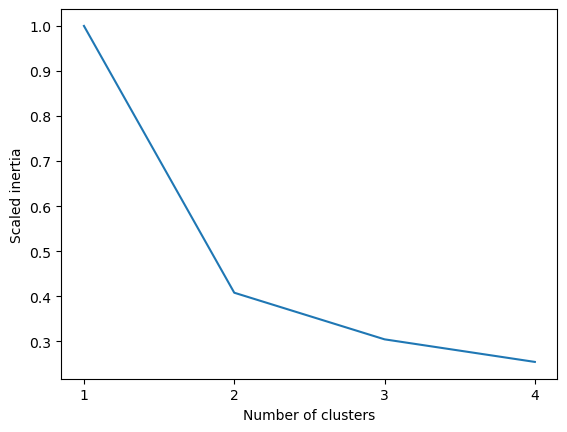

In [14]:
#now that we have the distance matrix we can perform K-means clustering. We start by looking at
#inertia and elbow method
#inertia and elbow method
range_n_clusters = range(1, 5, 1)
inertia_vals = []
for num_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=num_clusters)

    # Fit the model to the data
    clusterer.fit(js_dist_matrix)
    
    #clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001,
    #                verbose=0, random_state= 10, copy_x=True, algorithm='lloyd')
    
    #cluster_labels = clusterer.fit_predict(trace_X)
    inertia_vals.append(clusterer.inertia_)

#scale the inertia vals so that the first value is one
inertia_vals = np.array(inertia_vals)/inertia_vals[0]

#plot as a line plot
plt.plot(range_n_clusters, inertia_vals)
plt.xticks(range_n_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Scaled inertia")

#output inertia values
print(inertia_vals)

/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 The average silhouette_score is : 0.42431456782587273
For n_clusters = 3 The average silhouette_score is : 0.26421924096821753


/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4 The average silhouette_score is : 0.25289622170199505
For n_clusters = 5 The average silhouette_score is : 0.14484587348635228


/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 The average silhouette_score is : 0.14387729015932293
For n_clusters = 7 The average silhouette_score is : 0.10265698857703082


/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8 The average silhouette_score is : 0.08916964737000992
For n_clusters = 9 The average silhouette_score is : 0.08089579350718992


/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10 The average silhouette_score is : 0.06574247373604028


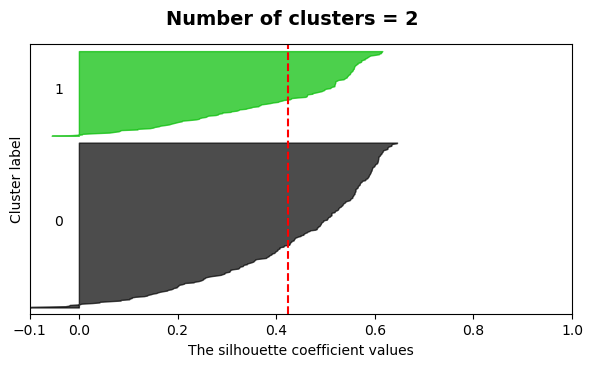

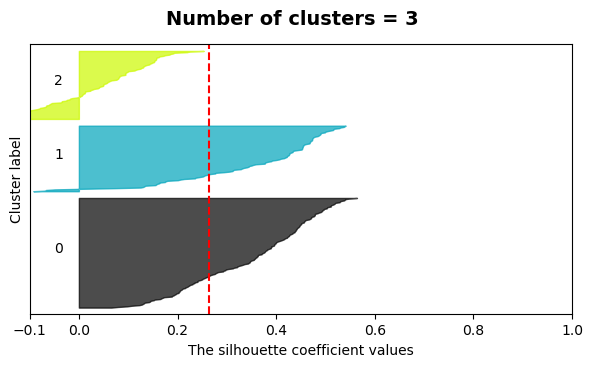

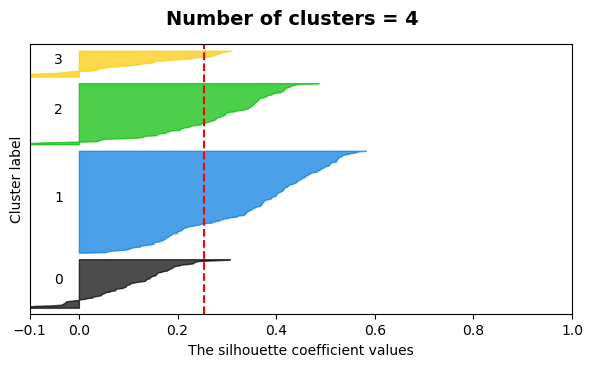

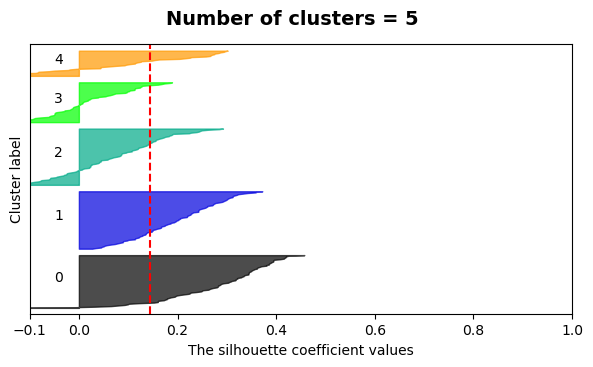

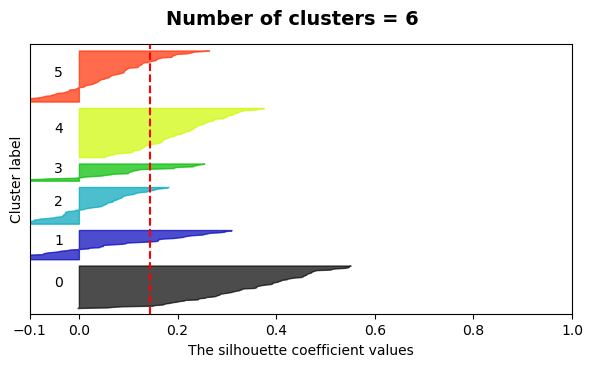

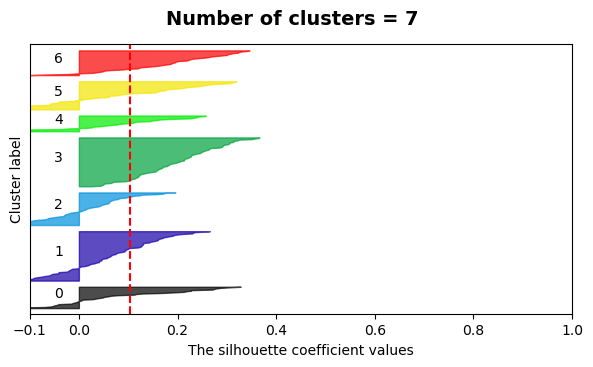

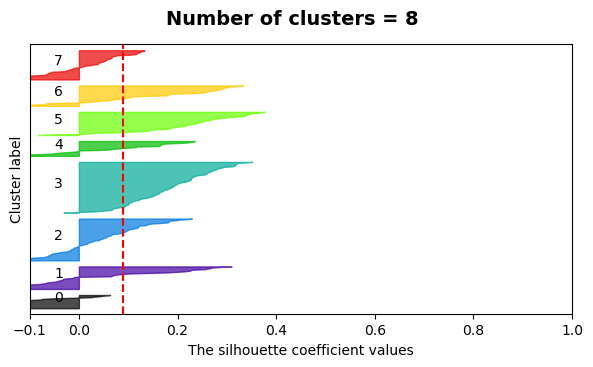

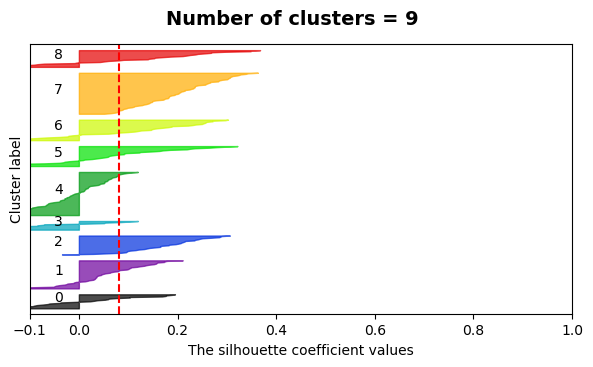

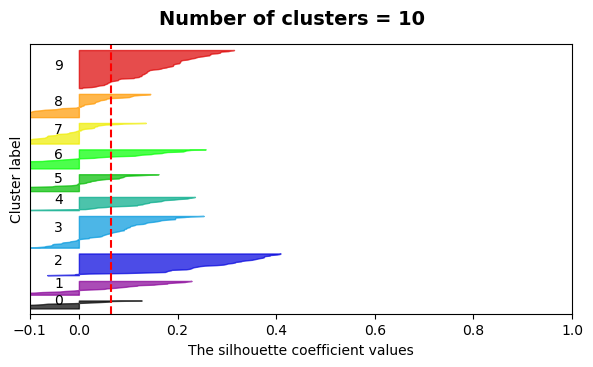

Text(0, 0.5, 'Silhouette Average')

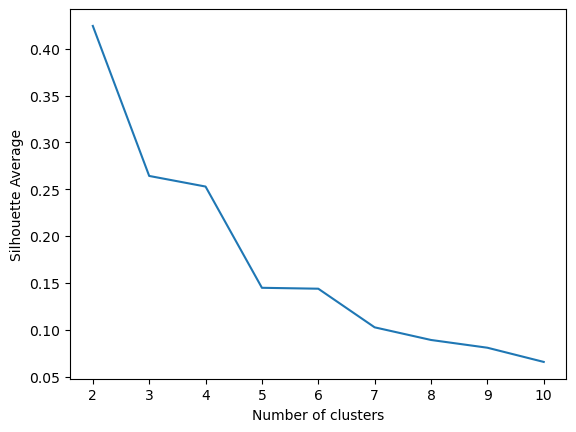

In [15]:
#silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_avg_list = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(7, 3.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(js_dist_matrix) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    clusterer.fit(js_dist_matrix)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(js_dist_matrix, clusterer.labels_, metric = 'precomputed')
    silhouette_avg_list.append(silhouette_avg)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(js_dist_matrix, clusterer.labels_, metric = 'precomputed')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusterer.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(
        #"Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        "Number of clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#also we plot just the average silhouette values by cluster number
plt.plot(range_n_clusters, silhouette_avg_list)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Average")

In [16]:
#examine centroids for two clusters
num_clusters = 2
clusterer = KMeans(n_clusters=num_clusters)

# Fit the model to the data
clusterer.fit(js_dist_matrix)

#add cluster label to traces
traces['ClusterLabel'] = clusterer.labels_

#split data by cluster label
X_0 =traces[traces['ClusterLabel'] == 0]['ProbArray']
X_1 =traces[traces['ClusterLabel'] == 1]['ProbArray']

#next we can compute the average probability array for each cluster
average_prob_arr_cluster0 = np.mean(X_0, axis = 0)
average_prob_arr_cluster1 = np.mean(X_1, axis = 0)

#and convert them into dictionaries
average_prob_dict_cluster0 = prob_array_to_dict(average_prob_arr_cluster0, all_ngrams_list)
average_prob_dict_cluster1 = prob_array_to_dict(average_prob_arr_cluster1, all_ngrams_list)

#finally check they are still normalised
print(np.sum(average_prob_arr_cluster0))
print(np.sum(average_prob_arr_cluster1))

1.0
1.0000000000000002


/Users/anthonyowen/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [17]:
#check which agents we have in which cluster
Agents_0 = traces[traces['ClusterLabel'] == 0]['AgentName']
Agents_1 = traces[traces['ClusterLabel'] == 1]['AgentName']

# Use Counter to count frequencies
frequency_count_0 = Counter(Agents_0)
frequency_count_1 = Counter(Agents_1)

# Print the frequency count
for value, count in frequency_count_0.items():
    print(f"{value}: {count} times")
    
for value, count in frequency_count_1.items():
    print(f"{value}: {count} times")

MediumB: 126 times
MediumA: 138 times
MediumA: 62 times
MediumB: 74 times


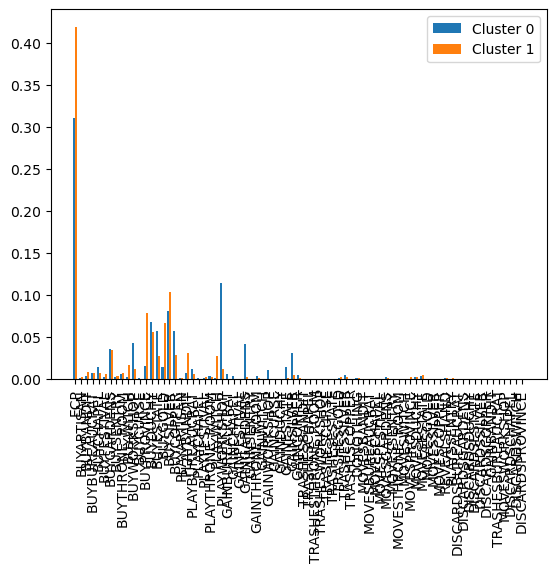

In [18]:
#function to plot two distributions side by side
def plot_distriution_comparison(distribution_dict_1, distribution_dict_2, label1 = '', label2 = '', threshold = 0):
    #find a common domain where all probbaility values are greater than a given threshold
    common_ngrams = return_common_ngrams_above_threshold(distribution_dict_1, distribution_dict_2, threshold)

    #extract probability arrays for these common n-grams
    distribution_dict_1_reduced = {key: distribution_dict_1[key] for key in common_ngrams}
    distribution_dict_2_reduced = {key: distribution_dict_2[key] for key in common_ngrams}
    distribution_array_1_reduced = prob_dict_to_array(distribution_dict_1_reduced)
    distribution_array_2_reduced = prob_dict_to_array(distribution_dict_2_reduced)

    #next plot probability distributions

    #need to convert common_ngrams into a list of strings as opposed to tuples containing strings
    common_ngrams_str = convert_ngram_tuples_to_strings(common_ngrams)

    #plot discrete probability distributions side by side

    # Set the width of the bars
    bar_width = 0.35

    # Calculate the x-coordinates for the bars
    x_values1 = np.arange(len(common_ngrams_str))
    x_values2 = x_values1 + bar_width

    plt.bar(x_values1, distribution_array_1_reduced, width=bar_width, label = label1) 
    plt.bar(x_values2, distribution_array_2_reduced, width=bar_width, label = label2)

    plt.xticks(x_values1 + bar_width / 2, common_ngrams_str)
    plt.xticks(rotation=90) 
    plt.ylim(threshold)
    plt.legend()
    plt.show()

plot_distriution_comparison(average_prob_dict_cluster0, average_prob_dict_cluster1, 'Cluster 0', 'Cluster 1')

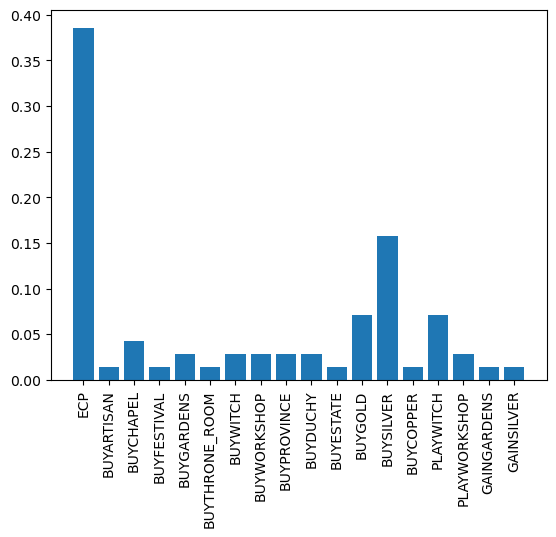

In [19]:
#plot example probability distribution for a given play trace for illustration purposes
prob_dict = traces['ProbDict'].iloc[0] 
prob_dict_nonzero = {gram: value for gram, value in prob_dict.items() if value > 0}
xvals = convert_ngram_tuples_to_strings(prob_dict_nonzero.keys())
yvals = prob_dict_nonzero.values()
plt.bar(xvals, yvals, label = 'DW strategy')
plt.xticks(rotation=90) 
plt.show()


In [20]:
#also compute centroid using weighted average as opposed to direct average
def calculate_centroid(vectors, dist_func, max_iterations=100, tolerance=1e-6):
    #Iteratively update centroid
    centroid = np.mean(vectors, axis=0)

    for _ in range(max_iterations):
        # Step 2: Calculate distance to centorid
        distances = np.array([dist_func(centroid, vec) for vec in vectors])

        # Step 3: Weighted sum based on inverse distances
        weights = 1 / (distances + 1e-9)  # Small constant added to avoid division by zero
        #weighted_sum = np.sum(weights[:, np.newaxis] * vectors, axis=0)
        weighted_sum = np.sum(weights * vectors, axis=0)

        # Step 4: Normalize the result
        new_centroid = weighted_sum / np.sum(weights)

        # Check convergence
        if np.linalg.norm(new_centroid - centroid) < tolerance:
            break

        centroid = new_centroid

    return centroid

/var/folders/60/sk8yhxb56ld6twrcnr2njl3h0000gn/T/ipykernel_6029/2851593303.py:66: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(p < eps, 0, np.where(q < eps,0, p * np.log(p / (1.0*q)))))
/var/folders/60/sk8yhxb56ld6twrcnr2njl3h0000gn/T/ipykernel_6029/2851593303.py:66: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p < eps, 0, np.where(q < eps,0, p * np.log(p / (1.0*q)))))
/var/folders/60/sk8yhxb56ld6twrcnr2njl3h0000gn/T/ipykernel_6029/2851593303.py:66: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p < eps, 0, np.where(q < eps,0, p * np.log(p / (1.0*q)))))


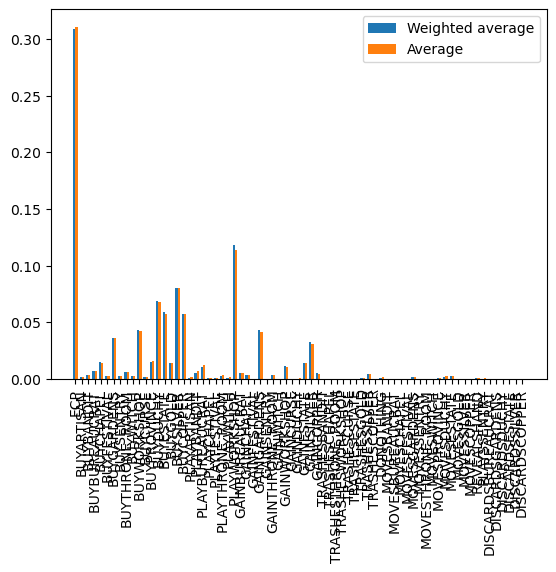

In [21]:
#recompute cluster 0 centroid using weighted averages and compare to direct average
X_0 =traces[traces['ClusterLabel'] == 0]['ProbArray']

weighted_avg_centroid = calculate_centroid(X_0, jensen_shannon_distance)
straight_avg_centroid = np.mean(X_0, axis = 0)

#plot side by side
weighted_avg_centroid_dict = prob_array_to_dict(weighted_avg_centroid, all_ngrams_list)
straight_avg_centroid_dict = prob_array_to_dict(straight_avg_centroid, all_ngrams_list)
plot_distriution_comparison(weighted_avg_centroid_dict, straight_avg_centroid_dict, 'Weighted average', 'Average')
